## Autoencoder 自编码器     
自编码器是一种执行数据压缩的网络架构，其中压缩和解压缩功能是从数据本身学习而来的。  

自编码器的一般思路是将你的输入数据传递给编码器，以创建输入的压缩表示，然后再将该表示传递给解码器，以获得重建后的数据。编码器和解码器都是用神经网络构建的。整个网络的训练方式是最小化输入和输出之间的差异，像正常情况下一样，这样，中间层将是输入数据的压缩表示，你可以从它构建原始数据。当然，会有一些信息丢失，基本上是因为单元减少了。  

在实践中，自编码器的压缩性能实际上比JPEG,MP3和MPEg或视频等传统方法要差，并且，自编码器在泛化到其训练数据集之外的数据集方面有困难，但近来，人们发现了它们在**图像去噪和降维方面**的用途。 


Autoencoder 是一种无监督的学习算法，主要用于数据的降维或者特征的抽取。在深度学习中，autoencoder可用于在训练阶段开始前，确定权重矩阵W的初始值。 它使用了反向传播算法，并让目标值等于输入值。   
我们构建一个尝试生成其输入数据的网络，但该网络具有一个窄的隐藏层用作输入数据的压缩表示。如下图：

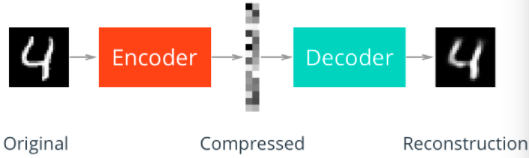

In [1]:
from IPython.display import Image
Image("23.png")

自动编码器是一种数据的压缩算法，其中数据的压缩和解压缩是数据相关的、有损的、从样本中自动学习的。在大部分提到自动编码器的场合，压缩和解压缩的函数是通过神经网络实现的。

如下例：   
### Convolutional Autoencoder(卷积自编码器)
使用MNIST数据集，我们使用卷积层提高自编码性能。加载模块和数据。

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt  

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


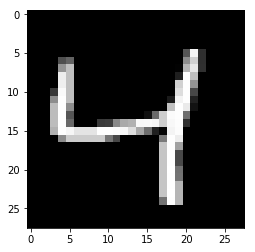

In [8]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28,28)),cmap='Greys_r')

### 网络体系结构   

网络的编码器部分将是一个典型的卷积金字塔。每个卷积层将遵循一个最大池层，以减少层的维数。解码器也许对你来说是新事物。解码器需要从窄表示转换成宽的重构图像。例如，表示可能是一个4x4x8最大池层。这是编码器的输出，也是解码器的输入。我们想从解码器得到一个28x28x1图像，所以需要从狭窄的解码器的输入层反向运作。下面的网络示意图如下所示。  

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)  
在这里，我们最后的编码层大小4x4x8 = 128。原始图像的大小28x28 = 784，所以编码向量是大约16%的原始图像的大小。这些只是建议的每个层的大小。请随意更改深度和大小，但请记住，我们的目标是找到输入数据的一个表示形式。

 #### 解码器将会做什么
解码器具有这些“上采样”层，你可能没有见过。首先，我将讨论一下哪些层不是。通常，你会看到反卷积-用来增加层的宽度和高度层。它们的工作原理几乎与卷积层完全相同，但是它反转了。在输入层的一步会在反卷积层形成一大步。例如，如果在输入层你有一个3x3的卷积核，一个3x3的patch将会减少为在卷积层的一个单元。相对而言，在输入层的一个单元，将会在反卷积层扩大成3x3的patch。反卷积是通常被称为“transpose convolution(转置卷积)”在tensorflow API中，[`tf.nn.conv2d_transpose`]。  
>- 缩小图像（或称为下采样（subsampled）或降采样（downsampled））的主要目的有两个：1、使得图像符合显示区域的大小；2、生成对应图像的缩略图。
>- 放大图像（或称为上采样（upsampling）或图像插值（interpolating））的主要目的是放大原图像,从而可以显示在更高分辨率的显示设备上。  

然而，在最终的图像中，反卷积层可能会导致棋盘格子状的伪影（artifact）。这是由于内核重叠造成的，可以通过设置步长和内核大小来避免这些重叠。这些棋盘效应可以通过在卷积层后使用最近邻或双线性插值（上采样）避免。在TensorFlow，在一个卷积层之后通过[`tf.image.resize_nearest_neighbor`]这是很容易做到的。  
> 练习：  建立上面所示的网络。请记住，步长为1和“SAME”填充的卷积层不会降低高度和宽度。那就是，如果输入的是28x28和卷积层步长为1和“SAME”的填充，卷积层也会是28x28。最大池层是用来减少宽度和高度的。步长为2将以2为单位缩小尺寸。Odena等人声称最近邻插值效果是最好的上采样，所以要作为一个参数使用`tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]

In [ ]:
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name='inputs')
targets_=tf.placeholder(tf.flloat32,(None,28,28,1),name='target')

# Encoder 
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same',activation =tf.nn.relu)
# Now 28x28x16  
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding='same')
# Now 14x14x16 
conv2 = tf.layers.conv2d(maxpool1, 8,(3,3),padding='same',activation=tf.nn.relu)
# Now 14x14x8
maxpool2 =tf.layers.max_pooling2d(conv2,(2,2),(2,2),padding='same')
# Now 7x7x8  
conv3= tf.layers.conv2d(maxpool2,8, (3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3,(2,2),(2,2),padding='same')
# Now 4x4x8

# Decoder
upsample1 = tf.image/resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8,(3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x8
